# Importing all the conversations

This is a bit trickier as you need to do something with all the conversations you're loading up.

---

Load up a tonne of libraries

In [1]:
import datetime
import json
import os
import pickle
import random
import re
import textwrap
from pathlib import Path
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull

import message_helpers as mh
from hangouts_loader import load_hangouts


In [2]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["font.sans-serif"] = ["Segoe UI Emoji"]


In [3]:
pickle_name = "all_convo.pickle"
pickle_path = Path(pickle_name)


Set your name here. This is so that you can take yourself out of some of the graphs. Because these are conversations, naievely, they go A B A B and so on, so you'll be roughly 50% of the messages, which makes other trends hard to see.

In [4]:
MY_NAME = "Ben Doherty"


In [5]:
def parse_obj(obj):
    """Unfuck facebook's message storage encoding.

    Facebook stores their messages in some kind of insane mix of latin 1 and utf-8
    This means that emoji and iOS punctuation are broken unless decoded with this.

    Args:
        obj (dict): a part of a facebook message

    Returns:
        dict: tht object, but not munted
    """
    for key in obj:
        if isinstance(obj[key], str):
            obj[key] = obj[key].encode("latin_1").decode("utf-8")
        elif isinstance(obj[key], list):
            obj[key] = list(
                map(
                    lambda x: x
                    if type(x) != str
                    else x.encode("latin_1").decode("utf-8"),
                    obj[key],
                )
            )
        pass
    return obj


def sumarise_convo(name, data, verbose=False):
    words = {}
    words[name] = data.content.str.cat(sep=" ")
    wordcount = len(words[name].split(" "))

    unique_words = set(words[name].split(" "))

    pool = " ".join([str(x) for x in data.content.to_list()]).lower()
    clean = re.sub(mh.PUNCTUATION_REGEX, " ", pool, flags=re.VERBOSE)
    # and replace it with a single space
    stopped = list(set([w for w in clean.split() if w not in mh.STOP_WORDS]))

    if verbose:
        print(
            f"{name} wrote {wordcount} words ({len(words[name])} characters)"
            f" and used {len(stopped)} different words."
        )
    return {
        "participant": name,
        "wordcount": wordcount,
        "unique_words": len(unique_words),
        "cleaned_unique": len(stopped),
    }


def get_message_length(message):
    if type(message) is str:
        return len(message)
    else:
        return len(str(message))


def replace_typographic_apostrophy(message):
    if type(message) is str:
        return message.replace("’", "'")
    else:
        return message


def load_whole_inbox(rootdir, platform="Facebook", verbose=False):
    conversations = []
    for d in os.listdir(rootdir):
        conversations.append(d)
    print(
        f"There are {len(conversations)} conversations to look at from {platform}. ({rootdir})"
    )
    # conversations

    convo_df_list = []

    for convo in os.listdir(rootdir):
        for f in os.listdir(os.path.join(rootdir, convo)):
            try:
                message_list = []
                path = os.path.join(os.path.join(rootdir, convo, f))
                if Path(path).is_file():
                    with open(path, "r") as fb_data:
                        messages = json.load(fb_data, object_hook=parse_obj)
                        message_list.extend(messages["messages"])

                if len(message_list) != 0:
                    df = pd.DataFrame(message_list)
                    df["source_convo"] = convo
                    df["datetime"] = df.timestamp_ms.apply(
                        lambda x: datetime.datetime.fromtimestamp(x / 1000.0)
                    )

                    if "content" in df.columns:
                        df["message_length"] = df.content.apply(get_message_length)
                        df.content = df.content.apply(replace_typographic_apostrophy)
                    else:
                        df["message_length"] = 0
                        df["content"] = np.nan

                    df["platform"] = platform

                    convo_df_list.append(df)
                    if verbose:
                        try:
                            print(convo, f)
                            print(f"{df.shape[0]} rows, between:", ", ".join(list(df.sender_name.unique())))
                            print()
                        except:
                            pass

            except Exception as e:
                print("exception", convo, e)
    print(f"finished with {platform}")
    return convo_df_list


In [6]:
fb_rootdir = "fb_data/messages/inbox"
ig_rootdir = "ig_data/inbox"

print("Loading from source files")
fb_convo_df_list = load_whole_inbox(fb_rootdir, platform="Facebook")
fb_convo_df_list_2 = load_whole_inbox(fb_rootdir + "_1", platform="Facebook")
fb_archived_threads = load_whole_inbox("fb_data/messages/archived_threads", platform="Facebook", verbose=True)
ig_convo_df_list = load_whole_inbox(ig_rootdir, platform="Instagram")
ho_convo_df_list = [load_hangouts()]

convo_df_list = (
    fb_convo_df_list + fb_convo_df_list_2 + ig_convo_df_list + ho_convo_df_list
)
# print(len(convo_df_list))
all_convo_df = pd.concat(convo_df_list)
print(f"done: all_convo_df has {all_convo_df.shape[0]} rows")


Loading from source files
There are 1214 conversations to look at from Facebook. (fb_data/messages/inbox)
finished with Facebook
There are 43 conversations to look at from Facebook. (fb_data/messages/inbox_1)
finished with Facebook
There are 6 conversations to look at from Facebook. (fb_data/messages/archived_threads)
catherineheatherflickand2others_36f1-zehrw message_1.json
6 rows, between: Ben Doherty, Ali Jane, Beverley Renders, Tish McCrohan, Eif Reynolds, Sue Terry

ilanarebeccapaulaand31others_djv402zenw message_1.json
23 rows, between: Ben Doherty, Andrew Kavanagh, Ginni Tory, Matt Brook, Pooky Hesmondhalgh, Josie Elt, Duncan Wagstaff, Kalani Kuruppu, Anna Watson, Lizzi Potter, Lizzy Westmacott, Rachel McHale, Charles Tarrant, David Collyer, Katie Cannon, John Richard Gale, Hannah Elphick, Jeffrey Arun Rubasingham, Leighanne DB, Angela Taylor, Gillian Chan, Anna Biddlestone

karinfrost_ytv2zmljrq message_1 (2).json
703 rows, between: Ben Doherty, Karin Frost

karinfrost_ytv2zmlj

In [7]:
print(
    f"Overall, there are {len(all_convo_df)}, messages in this dataset. "
    f"These come from about {len(all_convo_df.sender_name.unique())} people, "
    f"covering a period of {str(all_convo_df.datetime.max()-all_convo_df.datetime.min()).split(' days')[0]} days "
    f"between {all_convo_df.datetime.min():%B, %Y} and {all_convo_df.datetime.max():%B, %Y}. "
    f"Over {len(all_convo_df.platform.unique())} platforms:"
)
all_convo_df.platform.value_counts()


Overall, there are 1010751, messages in this dataset. These come from about 778 people, covering a period of 5472 days between January, 2007 and December, 2021. Over 3 platforms:


Facebook     783319
Hangouts     146211
Instagram     81221
Name: platform, dtype: int64

## Merge names

Some people have different names across different platforms, firstly let's get a list of unique names, and then define a dictionary that will say what to merge into what.

In [8]:
names = []
platform_names = {}
for platform, df in all_convo_df.groupby("platform"):
    vc = df.sender_name.value_counts()
    these_names = vc[vc > 100].index.to_list()
    names += these_names
    print("\n",platform, "\n",these_names)
    platform_names[platform] = set(these_names)
# print(platform_names)


 Facebook 
 ['Ben Doherty', 'Meike Wijers', 'Ivana Kuzmanovska', 'Jenn Martin', 'Lucy Rimmer', 'Bree-Danielle Wyatt', 'Irina Belova', 'Karin Frost', 'Maddie Johanson', 'Natalie Barnes', 'Annisa Rivera Rizal', 'Katherine Withnell', 'Erika Bloomingdale', 'Elizabeth Deacon', 'Jülz Milthorpe', 'Sarah Maloof', 'Nazmul Azim Khan', 'Emma Stewart', 'Thearlaich Ogilive', 'Byron Sullivan', 'Antonia Sheil', 'Alessandra Moschella', 'Ishaan Varshney', 'Jodie Hinton', 'Tiara Dobbs', '', 'Shelda Kristie', 'Ali Jane', 'Adam Pigott', 'Marc Micuta', 'Debbie Hodge', 'Jess Howard', 'Brndn Wlsh', 'Rachel Bee', 'Bethan Ellis-Jones', 'Sebastian Winnett', 'Baptiste Higgs', 'Alexander Lee', 'Shawnee Finlayson', 'MattWho Bell', 'Barnaby Bennett', 'Kelly Melrose', 'Elynda Ma', 'Heather Louise', 'Aiden Ray', 'Lydia Durkin George', 'Barry Dineen', 'Y-e Ho', 'Lauren Maree', 'Yien Yien Soo', 'Clare Jackson', 'John Richard Gale', 'Bianca Toth', 'Anthea Murray', 'Laurel Fox', 'Deezy Jefferson', 'Melanie Mury', 'Other

In [9]:
fb_s = set(platform_names["Facebook"])
ig_s = set(platform_names["Instagram"])
ho_s = set(platform_names["Hangouts"])
# print(fb_s.symmetric_difference(ig_s))
# print(fb_s.intersection(ig_s))
print("\nshows in all platforms", fb_s & ig_s & ho_s)
print("\nshows in fb and ig", fb_s & ig_s)
print("\nfb only", fb_s - ig_s)
print("\nig only", ig_s - fb_s)



shows in all platforms {'Ben Doherty', 'Alessandra Moschella', 'Lucy Rimmer', 'Irina Belova'}

shows in fb and ig {'Alessandra Moschella', 'Meike Wijers', 'Natalie Barnes', 'Katherine Withnell', 'Maddie Johanson', 'Brooke Jackson', 'Shelda Kristie', 'Ben Doherty', 'Bree-Danielle Wyatt', 'Jenn Martin', 'Irina Belova', 'Lucy Rimmer'}

fb only {'', 'Angela Layana', 'Deezy Jefferson', 'Clarrie Morabito', 'Thearlaich Ogilive', 'Y-e Ho', 'Jared Na', 'Joseph Samuel', 'Brndn Wlsh', 'Byron Sullivan', 'Lydia Durkin George', 'Jess Howard', 'Other User', 'Julia Bouvy Holland', 'Hannah Elphick', 'Talor Browne', 'Shanny Lam', 'Nick Flutter', 'Lauren Maree', 'Sarah Farrell', 'Barnaby Bennett', 'Kameron Ahmad', 'Josh Mason', 'Ali Jane', 'Baptiste Higgs', 'Anthea Murray', 'Bethan Ellis-Jones', 'Facebook for Business', 'Nicole Sarapata', 'Adam Pigott', 'Rachel Elizabeth Smith', 'Yien Yien Soo', 'Polly Brown', 'Melanie Mury', 'Adele Varcoe', 'Gen Pitkeathly', 'Sebastian Winnett', 'Antonia Sheil', 'Nazmu


Use the lists above to work out who shows up in more than one list, but under different names, and then use the thesaurus below to map their names to a single value.

In [10]:
def fold_names(input_name):
    annisa = "Annisa Rivera Rizal"
    byron = "Byron Sullivan"
    charlie = "Charles Ogilvie"
    clarrie = "Clarrie Morabito"
    ivana = "Ivana Kuzmanovska"
    jess = "Jess Howard"
    jodie = "Jodie Hinton"
    julz = "Jülz Milthorpe"
    karin = "Karin Ke"
    tones = "Antonia Sheil"
    thesaurus = {
        "Byron Sullivan": byron,
        "Byron": byron,
        "Thearlaich Ogilive": charlie,
        "Charles OGILVIE": charlie,
        "Charles Ogilvie": charlie,
        "Karin Frost": karin,
        "karin ke": karin,
        "Ivana Kuzmanovska": ivana,
        "ivana kuzmanovska": ivana,
        "Jülz": julz,
        "Jülz Milthorpe": julz,
        "jesshoward": jess,
        "Jess Howard": jess,
        "Jodie": jodie,
        "Tones": tones,
        "annisarivera": annisa,
        "Clarrie": clarrie,
        "tanyaruby": "Tanya P",
        "iflaneuse": "Nicole Gardiner",
        "Frank": "Francis Lockie",
    }
    new_name = thesaurus.get(input_name, input_name)
    # if new_name != input_name:
    #     print(f"renamed {input_name} to {new_name}")
    return new_name


all_convo_df["input_names"] = all_convo_df.sender_name
all_convo_df.sender_name = all_convo_df.sender_name.apply(fold_names)


<AxesSubplot:>

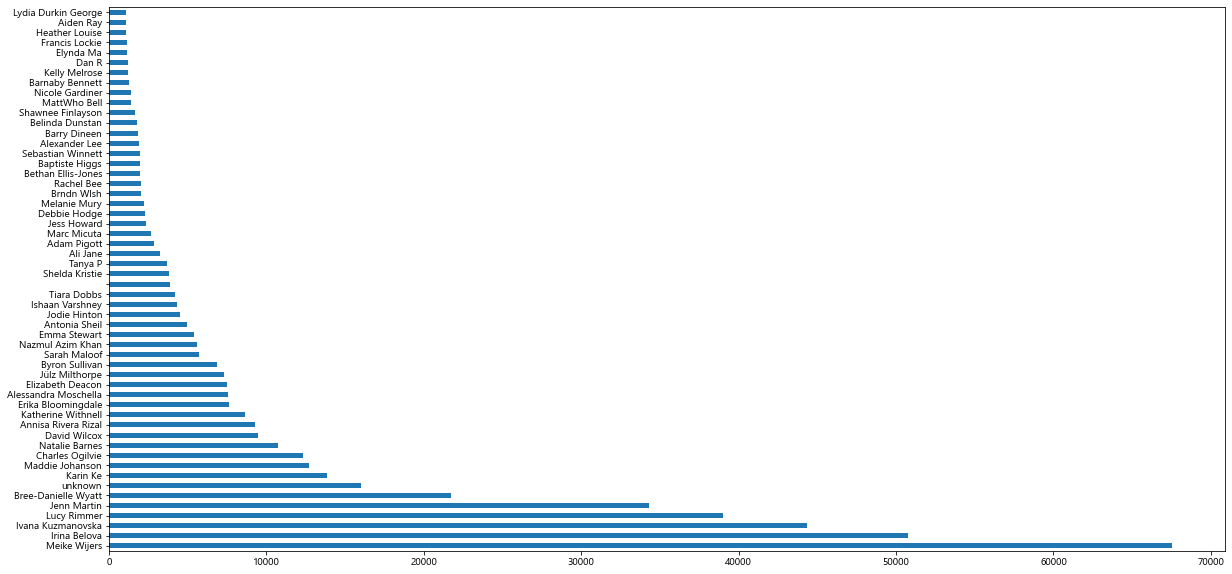

In [11]:
vc = all_convo_df.sender_name.value_counts()
vc[(vc>1000) & (vc<100000)].plot(kind="barh")

## Initials

To label a lot of graphs we'll need a compact way to represent people, so I (Ben Doherty) can be shown as BD.

In [12]:
all_initials = all_convo_df.sender_name.value_counts().to_dict()
initials_pool = []
for name in all_initials.keys():
    split = [x for x in re.split("[ \.-]", name) if x != ""]
    try:
        initials = "".join([n[0] for n in split]).upper()
        if initials in initials_pool:
            # print("uh oh, double up on", initials, name, initials_pool)
            initials = "".join([n[0] for n in split]).upper() + name.split()[-1][1]
            # print("replaced with", initials)
            if initials in initials_pool:
                initials = (
                    split[0].upper()
                    + split[1].lower()
                    + split[-1].upper()
                    + split[-2].lower()
                )
                if initials in initials_pool:
                    print("fuck, complicated", name)
                    initials = name+"x"
    except Exception as e:
        # print(name, e, split)
        initials = name+"x"
    all_initials[name] = initials
    initials_pool.append(initials)

all_convo_df["initials"] = all_convo_df.sender_name.apply(lambda x: all_initials[x])
all_convo_df[["sender_name", "content", "initials"]].drop_duplicates(subset="initials").sample(10)


,sender_name,content,initials
33240,Alex Lee,NaN,ALe
1,Adam Holloway,Was it any good? \n,AHo
2,Joey Rumbold,Hi Ben \nI can pick up early this evening if t...,JRu
0,Rachel Hamblin,"yup - got hitched in july, happy as Larry! Sti...",RH
2,T 👁 A,And I'm moving city side soon! Finally haha,T👁A
4,Chris Stabback,Adaaaaaaaam I can't make it but happy birthday...,CHRISstabbackSTABBACKchris
3,Hugh Turner,That's from DeeAndre,HT
0,Daminda Yapa,"Love the profile picture, looks like you about...",DAMINDAyapaYAPAdaminda
7,Kathryn Dalecki,Block says he has no time tonight...,KD
3,Jess Howard,Just sick of being on my phone!,JHo


## Gender

I've had to make a new table, and just make up what people are assigning, but I think it's basically right. This will show if I'm biased in one way or the other in my messaging.

I've put myself in with a gender of `me` so that I can tell where the split really lies, as I'm &thickapprox; 50% of the messages.

In [13]:
gender_file = "gender.csv"
gender_df = pd.read_csv(gender_file)
all_convo_df = pd.merge(all_convo_df, gender_df, on="sender_name")
all_convo_df.sample(4)

,sender_name,timestamp_ms,content,type,is_unsent,users,source_convo,datetime,message_length,platform,...,share,ip,gifs,files,audio_files,missed,event_id,input_names,initials,gender
53497,Ben Doherty,1.543828e+12,I left the appt open,Generic,False,NaN,brndnwlsh_x4cjyyofrq,2018-12-03 20:10:11.459,20,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ben Doherty,BD,me
295293,Ben Doherty,1.611874e+12,But you don't need to hang I guess,Generic,False,NaN,meikewijers_ypa4ghjk_q,2021-01-29 09:50:29.603,34,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ben Doherty,BD,me
170155,Ben Doherty,1.588338e+12,Maybe I'll get there before my body gives out ...,Generic,False,NaN,jennmartin_8rjjopoglw,2020-05-01 23:06:58.159,51,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ben Doherty,BD,me
821845,Jenn Martin,1.617515e+12,Send me a video of you shaping it,Generic,False,NaN,jennmartin_8rjjopoglw,2021-04-04 15:46:43.593,33,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jenn Martin,JM,f


In [14]:
gender_list = ["me", "f", "m"] # edit this to match your gender_file
not_assigned = all_convo_df[[x not in gender_list for x in all_convo_df.gender]]
if not_assigned.shape[0] != 0:
    print(
        f"you need to tag people in the gender file: {gender_file}\n"
        "If you don't want to, just comment this and the section above out"
    )
    not_assigned.sender_name.valuecounts()


In [15]:
all_convo_df[[x not in gender_list for x in all_convo_df.gender]].shape

(0, 25)

In [16]:
def clean_and_stop(content, as_list=False):
    try:
        clean = re.sub(
            mh.PUNCTUATION_REGEX,
            " ",
            content,
            flags=re.VERBOSE,  # and replace it with a single space
        )
        stopped = [w.lower() for w in clean.split() if w.lower() not in mh.STOP_WORDS]
        # print(content, "=>", stopped)
        if as_list:
            return stopped
        else:
            return " ".join(stopped)
    except Exception as e:
        # print(content, e)
        return content


all_convo_df["clean_content"] = all_convo_df.content.apply(clean_and_stop)


In [17]:
print(f"saving new pickle: {pickle_path}")
pd.to_pickle(all_convo_df, pickle_path)
print("done")

saving new pickle: all_convo.pickle
done
